# Better version, with first augmentaion, then rest of the work <Final Solution)

# Older code , just basic pre-processing

In [ ]:
# Improved Medical Image Classification with Proper Data Handling

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from PIL import Image
import shutil
import pickle
import gc
from sklearn.neighbors import KNeighborsClassifier

# ========================================================================================
# IMPROVED SECTION 1: PROPER DATA SPLITTING TO AVOID LEAKAGE
# ========================================================================================

def split_original_dataset(original_path, train_path, test_path, test_size=0.2):
    """
    Split original dataset BEFORE augmentation to avoid data leakage
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    for disease in diseases:
        disease_dir = os.path.join(original_path, disease)
        if not os.path.exists(disease_dir):
            continue
            
        # Get all image files
        image_files = [f for f in os.listdir(disease_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        # Split into train and test
        train_files, test_files = train_test_split(
            image_files, test_size=test_size, random_state=42
        )
        
        # Create directories
        train_disease_dir = os.path.join(train_path, disease)
        test_disease_dir = os.path.join(test_path, disease)
        os.makedirs(train_disease_dir, exist_ok=True)
        os.makedirs(test_disease_dir, exist_ok=True)
        
        # Copy files to respective directories
        for file in train_files:
            src = os.path.join(disease_dir, file)
            dst = os.path.join(train_disease_dir, file)
            shutil.copy2(src, dst)
            
        for file in test_files:
            src = os.path.join(disease_dir, file)
            dst = os.path.join(test_disease_dir, file)
            shutil.copy2(src, dst)
        
        print(f"{disease}: {len(train_files)} train, {len(test_files)} test")

# ========================================================================================
# IMPROVED SECTION 2: AUGMENT ONLY TRAINING DATA
# ========================================================================================

def augment_training_data(train_path, augmented_train_path, target_per_class=500):
    """
    Augment only the training data to balance classes
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    augmenter = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for disease in diseases:
        input_dir = os.path.join(train_path, disease)
        output_dir = os.path.join(augmented_train_path, disease)
        os.makedirs(output_dir, exist_ok=True)
        
        if not os.path.exists(input_dir):
            continue
            
        image_files = [f for f in os.listdir(input_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        # Copy original images
        for img_file in image_files:
            shutil.copy2(os.path.join(input_dir, img_file), 
                        os.path.join(output_dir, img_file))
        
        # Calculate augmentation needed
        current_count = len(image_files)
        if current_count >= target_per_class:
            print(f"{disease}: {current_count} images (no augmentation needed)")
            continue
            
        extra_needed = target_per_class - current_count
        augs_per_image = extra_needed // current_count
        
        count = 0
        for img_file in image_files:
            if count >= extra_needed:
                break
                
            img_path = os.path.join(input_dir, img_file)
            try:
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                
                aug_iter = augmenter.flow(x, batch_size=1)
                
                for j in range(augs_per_image):
                    if count >= extra_needed:
                        break
                    
                    aug_img = next(aug_iter)[0].astype('uint8')
                    aug_pil = Image.fromarray(aug_img)
                    
                    base_name = os.path.splitext(img_file)[0]
                    aug_name = f"{base_name}_aug_{j+1}.jpg"
                    aug_path = os.path.join(output_dir, aug_name)
                    
                    aug_pil.save(aug_path, 'JPEG', quality=95)
                    count += 1
                    
            except Exception as e:
                print(f"Error augmenting {img_file}: {e}")
                
        print(f"{disease}: {current_count} → {len(os.listdir(output_dir))} images")

# ========================================================================================
# IMPROVED SECTION 3: MEMORY-EFFICIENT FEATURE EXTRACTION
# ========================================================================================

class FeatureExtractor:
    def __init__(self):
        self.base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    def extract_features_batch(self, directory, batch_size=32):
        """
        Extract features in batches to manage memory efficiently
        """
        features = []
        labels = []
        diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
        for class_name in diseases:
            class_dir = os.path.join(directory, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
            print(f"Processing {len(image_files)} images from {class_name}...")
            
            # Process in batches
            for i in range(0, len(image_files), batch_size):
                batch_files = image_files[i:i+batch_size]
                batch_images = []
                batch_labels = []
                
                for img_file in batch_files:
                    img_path = os.path.join(class_dir, img_file)
                    try:
                        img = load_img(img_path, target_size=(224, 224))
                        x = img_to_array(img)
                        x = tf.keras.applications.vgg16.preprocess_input(x)
                        batch_images.append(x)
                        batch_labels.append(class_name)
                    except Exception as e:
                        print(f"Error loading {img_file}: {e}")
                
                if batch_images:
                    batch_images = np.array(batch_images)
                    batch_features = self.base_model.predict(batch_images, verbose=0)
                    
                    for j, feature in enumerate(batch_features):
                        features.append(feature.flatten())
                        labels.append(batch_labels[j])
                
                # Clear memory
                del batch_images, batch_features
                gc.collect()
                
                if i % (batch_size * 10) == 0:
                    print(f"  Processed {min(i + batch_size, len(image_files))}/{len(image_files)} images")
        
        return np.array(features), np.array(labels)



# last Implementation  (complet code, lr to all ml algo , but low accuracy on knn)

In [1]:
# Improved Medical Image Classification with Proper Data Handling

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from PIL import Image
import shutil
import pickle
import gc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize, StandardScaler
import seaborn as sns
import pandas as pd

# ========================================================================================
# IMPROVED SECTION 1: PROPER DATA SPLITTING TO AVOID LEAKAGE
# ========================================================================================

def split_original_dataset(original_path, train_path, test_path, test_size=0.2):
    """
    Split original dataset BEFORE augmentation to avoid data leakage
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    for disease in diseases:
        disease_dir = os.path.join(original_path, disease)
        if not os.path.exists(disease_dir):
            continue
            
        # Get all image files
        image_files = [f for f in os.listdir(disease_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        # Split into train and test
        train_files, test_files = train_test_split(
            image_files, test_size=test_size, random_state=42
        )
        
        # Create directories
        train_disease_dir = os.path.join(train_path, disease)
        test_disease_dir = os.path.join(test_path, disease)
        os.makedirs(train_disease_dir, exist_ok=True)
        os.makedirs(test_disease_dir, exist_ok=True)
        
        # Copy files to respective directories
        for file in train_files:
            src = os.path.join(disease_dir, file)
            dst = os.path.join(train_disease_dir, file)
            shutil.copy2(src, dst)
            
        for file in test_files:
            src = os.path.join(disease_dir, file)
            dst = os.path.join(test_disease_dir, file)
            shutil.copy2(src, dst)
        
        print(f"{disease}: {len(train_files)} train, {len(test_files)} test")

# ========================================================================================
# IMPROVED SECTION 2: AUGMENT ONLY TRAINING DATA
# ========================================================================================

def augment_training_data(train_path, augmented_train_path, target_per_class=500):
    """
    Augment only the training data to balance classes
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    augmenter = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for disease in diseases:
        input_dir = os.path.join(train_path, disease)
        output_dir = os.path.join(augmented_train_path, disease)
        os.makedirs(output_dir, exist_ok=True)
        
        if not os.path.exists(input_dir):
            continue
            
        image_files = [f for f in os.listdir(input_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        # Copy original images
        for img_file in image_files:
            shutil.copy2(os.path.join(input_dir, img_file), 
                        os.path.join(output_dir, img_file))
        
        # Calculate augmentation needed
        current_count = len(image_files)
        if current_count >= target_per_class:
            print(f"{disease}: {current_count} images (no augmentation needed)")
            continue
            
        extra_needed = target_per_class - current_count
        augs_per_image = extra_needed // current_count
        
        count = 0
        
        for img_file in image_files:
            if count >= extra_needed:
                break
                
            img_path = os.path.join(input_dir, img_file)
            try:
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                
                aug_iter = augmenter.flow(x, batch_size=1)
                
                for j in range(augs_per_image):
                    if count >= extra_needed:
                        break
                    
                    aug_img = next(aug_iter)[0].astype('uint8')
                    aug_pil = Image.fromarray(aug_img)
                    
                    base_name = os.path.splitext(img_file)[0]
                    aug_name = f"{base_name}_aug_{j+1}.jpg"
                    aug_path = os.path.join(output_dir, aug_name)
                    
                    aug_pil.save(aug_path, 'JPEG', quality=95)
                    count += 1
                    
            except Exception as e:
                print(f"Error augmenting {img_file}: {e}")
                
        print(f"{disease}: {current_count} → {len(os.listdir(output_dir))} images")

# ========================================================================================
# IMPROVED SECTION 3: MEMORY-EFFICIENT FEATURE EXTRACTION
# ========================================================================================

class FeatureExtractor:
    def __init__(self):
        self.base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    def extract_features_batch(self, directory, batch_size=32):
        """
        Extract features in batches to manage memory efficiently
        """
        features = []
        labels = []
        
        diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
        for class_name in diseases:
            class_dir = os.path.join(directory, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
            print(f"Processing {len(image_files)} images from {class_name}...")
            
            # Process in batches
            for i in range(0, len(image_files), batch_size):
                batch_files = image_files[i:i+batch_size]
                batch_images = []
                batch_labels = []
                
                for img_file in batch_files:
                    img_path = os.path.join(class_dir, img_file)
                    try:
                        img = load_img(img_path, target_size=(224, 224))
                        x = img_to_array(img)
                        x = tf.keras.applications.vgg16.preprocess_input(x)
                        batch_images.append(x)
                        batch_labels.append(class_name)
                    except Exception as e:
                        print(f"Error loading {img_file}: {e}")
                
                if batch_images:
                    batch_images = np.array(batch_images)
                    batch_features = self.base_model.predict(batch_images, verbose=0)
                    
                    for j, feature in enumerate(batch_features):
                        features.append(feature.flatten())
                        labels.append(batch_labels[j])
                
                # Clear memory
                del batch_images, batch_features
                gc.collect()
                
                if i % (batch_size * 10) == 0:
                    print(f"  Processed {min(i + batch_size, len(image_files))}/{len(image_files)} images")
        
        return np.array(features), np.array(labels)




# Define paths

original_path = "/kaggle/input/four-diseases-dataset/Dataset"
train_path = "/kaggle/working/train_dataset"
test_path = "/kaggle/working/test_dataset"
augmented_train_path = "/kaggle/working/augmented_train_dataset"

# Step 1: Split original dataset
print("Step 1: Splitting original dataset...")
split_original_dataset(original_path, train_path, test_path)

# Step 2: Augment training data
print("\nStep 2: Augmenting training data...")
augment_training_data(train_path, augmented_train_path)

# Step 3: Extract features
print("\nStep 3: Extracting features...")
feature_extractor = FeatureExtractor()

# Extract training features
    
X_train, y_train = feature_extractor.extract_features_batch(augmented_train_path)


# Extract test features

X_test, y_test = feature_extractor.extract_features_batch(test_path)



2025-07-18 09:01:17.099678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752829277.292010      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752829277.344622      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Step 1: Splitting original dataset...
Monkeypox: 80 train, 20 test
Pemphigus: 80 train, 20 test
Seborrheic keratosis: 80 train, 20 test
Squamous cell carcinoma: 80 train, 20 test

Step 2: Augmenting training data...
Monkeypox: 80 → 480 images
Pemphigus: 80 → 480 images
Seborrheic keratosis: 80 → 480 images
Squamous cell carcinoma: 80 → 480 images

Step 3: Extracting features...


I0000 00:00:1752829306.668493      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Processing 480 images from Monkeypox...


I0000 00:00:1752829309.217192      96 service.cc:148] XLA service 0x7fb8e4004630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752829309.218009      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752829309.347175      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752829316.909184      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Processed 32/480 images
  Processed 352/480 images
Processing 480 images from Pemphigus...
  Processed 32/480 images
  Processed 352/480 images
Processing 480 images from Seborrheic keratosis...
  Processed 32/480 images
  Processed 352/480 images
Processing 480 images from Squamous cell carcinoma...
  Processed 32/480 images
  Processed 352/480 images
Processing 20 images from Monkeypox...
  Processed 20/20 images
Processing 20 images from Pemphigus...
  Processed 20/20 images
Processing 20 images from Seborrheic keratosis...
  Processed 20/20 images
Processing 20 images from Squamous cell carcinoma...
  Processed 20/20 images


In [33]:
print(X_test[0])

[0.         0.         7.2707577  ... 0.         0.67117125 0.        ]


# Model's Evaluation Functions

In [2]:
# ========================================================================================
# MODEL EVALUATION FUNCTIONS
# ========================================================================================

def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_basic_metrics(y_true, y_pred, model_name):
    """
    Calculate basic evaluation metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_pred_proba, label_encoder, model_name):
    """
    Plot ROC curve for multi-class classification
    """
    classes = label_encoder.classes_
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)
    
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred, labels, model_name):
    """
    Print detailed classification report
    """
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))



# Machine Learning Models

# KNN


Step 4: Encoding labels...
Training features shape: (1920, 25088)
Test features shape: (80, 25088)
Classes: ['Monkeypox' 'Pemphigus' 'Seborrheic keratosis' 'Squamous cell carcinoma']
Training K-Nearest Neighbors...

K-Nearest Neighbors Results:
Accuracy: 0.6875
Precision: 0.7097
Recall: 0.6875
F1-Score: 0.6869

K-Nearest Neighbors Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.80      0.80      0.80        20
              Pemphigus       0.85      0.55      0.67        20
   Seborrheic keratosis       0.59      0.80      0.68        20
Squamous cell carcinoma       0.60      0.60      0.60        20

               accuracy                           0.69        80
              macro avg       0.71      0.69      0.69        80
           weighted avg       0.71      0.69      0.69        80



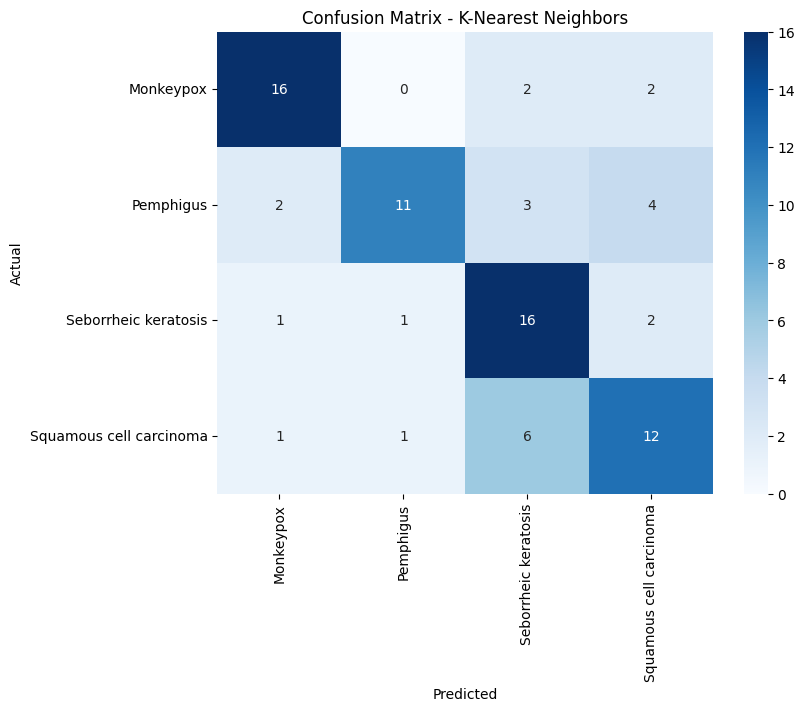

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


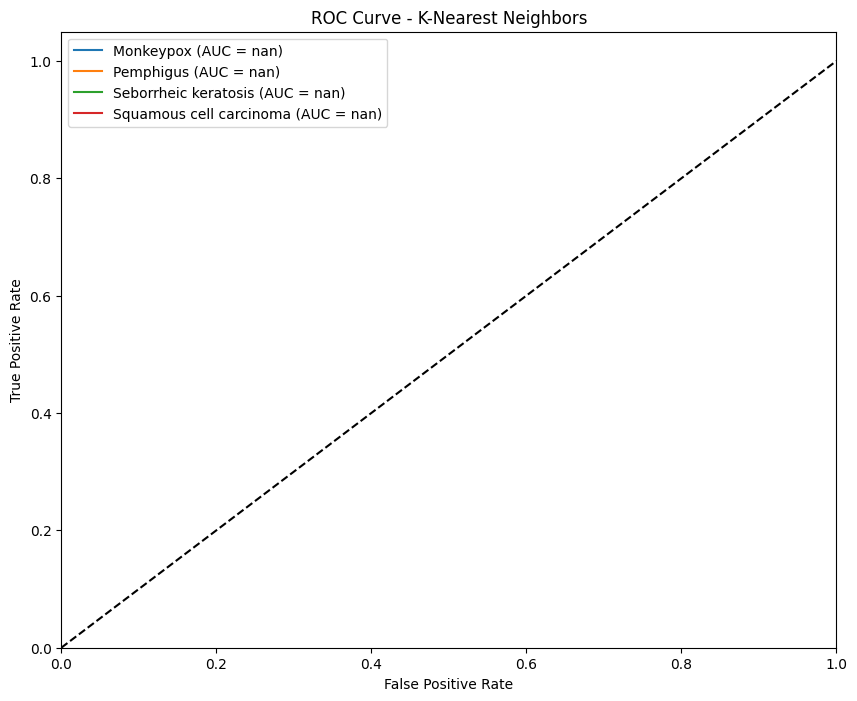

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler


def train_knn(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training K-Nearest Neighbors...")
    
    pca = PCA(n_components=0.95, random_state = 12)
    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)
    model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine', algorithm='brute')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "K-Nearest Neighbors")
    return model, accuracy




print("\nStep 4: Encoding labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Classes: {label_encoder.classes_}")
knn_model, knn_accuracy = train_knn(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Knn inference 

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Load the feature extractor ---
class FeatureExtractor:
    def __init__(self):
        self.base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    def extract_features(self, image_path):
        try:
            img = load_img(image_path, target_size=(224, 224))
            x = img_to_array(img)
            x = tf.keras.applications.vgg16.preprocess_input(x)
            x = np.expand_dims(x, axis=0)
            features = self.base_model.predict(x, verbose=0)
            return features.flatten().reshape(1, -1)
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None



def predict_single_image(image_path, model, pca, scaler, label_encoder, feature_extractor):
    # Step 1: Extract VGG16 features
    features = feature_extractor.extract_features(image_path)
    if features is None:
        print("Failed to extract features.")
        return None, {}

    # Step 2: Apply same PCA and scaler as used in training
    features_pca = pca.transform(features)
    features_scaled = scaler.transform(features_pca)

    # Step 3: Predict
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]

    # Step 4: Decode prediction
    predicted_class = label_encoder.inverse_transform([prediction])[0]

    # Step 5: Prepare confidence scores
    confidence_scores = {
        label_encoder.classes_[i]: float(probabilities[i])
        for i in range(len(probabilities))
    }

    # Print results
    print(f"\n✅ Prediction for: {image_path}")
    print(f"Predicted Disease: **{predicted_class}**")
    print("\nConfidence for all classes:")
    for cls, prob in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"  {cls}: {prob:.4f}")

    return predicted_class, confidence_scores

# Assuming these are already created after training:
# knn_model, pca, scaler, label_encoder, X_train, y_train, X_test, y_test

# Step 1: Initialize the feature extractor
feature_extractor = FeatureExtractor()

# Step 2: Predict
image_path = "/kaggle/input/four-diseases-dataset/Dataset/Pemphigus/img_0.jpg"  # Change as needed

predicted_class, confidence_scores = predict_single_image(
    image_path=image_path,
    model=knn_model,
    pca=pca,
    scaler=scaler,
    label_encoder=label_encoder,
    feature_extractor=feature_extractor
)






✅ Prediction for: /kaggle/input/four-diseases-dataset/Dataset/Pemphigus/img_0.jpg
Predicted Disease: **Pemphigus**

Confidence for all classes:
  Pemphigus: 1.0000
  Monkeypox: 0.0000
  Seborrheic keratosis: 0.0000
  Squamous cell carcinoma: 0.0000


# Upload a random file to check, whether the prediction is right or wrong

In [ ]:
from PIL import Image
import os

# Step 1: Load the image
img_path = '/kaggle/input/four-diseases-dataset/Dataset/Pemphigus/img_220.jpg'

img = Image.open(img_path)

# Step 2: Display the image
img.show()  # This might not work well on Kaggle; use matplotlib below instead

# Alternative (better for Kaggle): Display using matplotlib
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Step 3: Save the image to a different location (e.g., /kaggle/working/saved_images/)
output_dir = '/kaggle/working/saved_image_final'
os.makedirs(output_dir, exist_ok=True)

# Save the image
output_path = os.path.join(output_dir, 'saved_test_final.jpg')
img.save(output_path)

print("✅ Image saved to:", output_path)


# Logistic Regression 

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8500
Precision: 0.8511
Recall: 0.8500
F1-Score: 0.8503

Logistic Regression Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.89      0.85      0.87        20
              Pemphigus       0.95      0.95      0.95        20
   Seborrheic keratosis       0.75      0.75      0.75        20
Squamous cell carcinoma       0.81      0.85      0.83        20

               accuracy                           0.85        80
              macro avg       0.85      0.85      0.85        80
           weighted avg       0.85      0.85      0.85        80



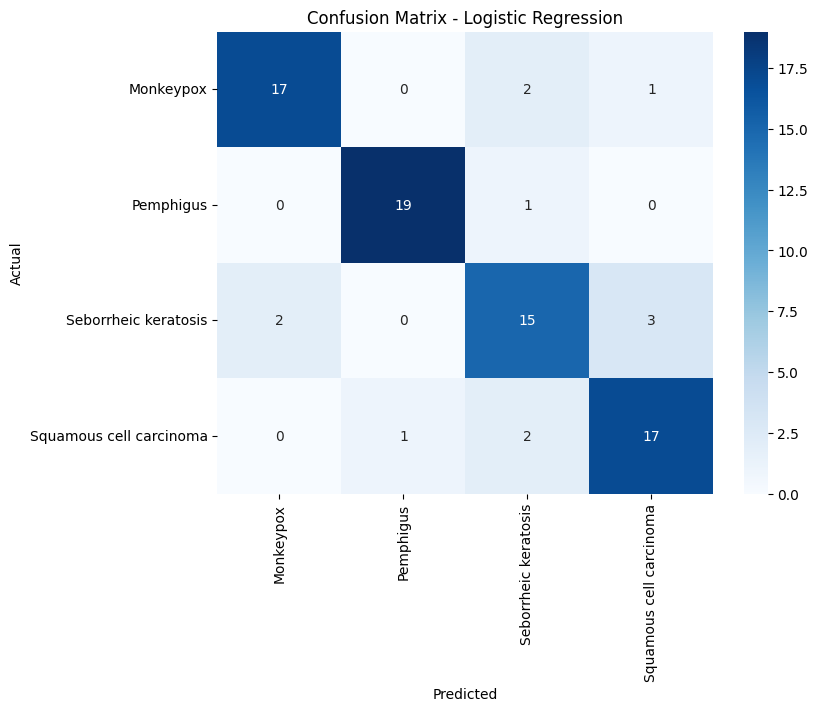

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


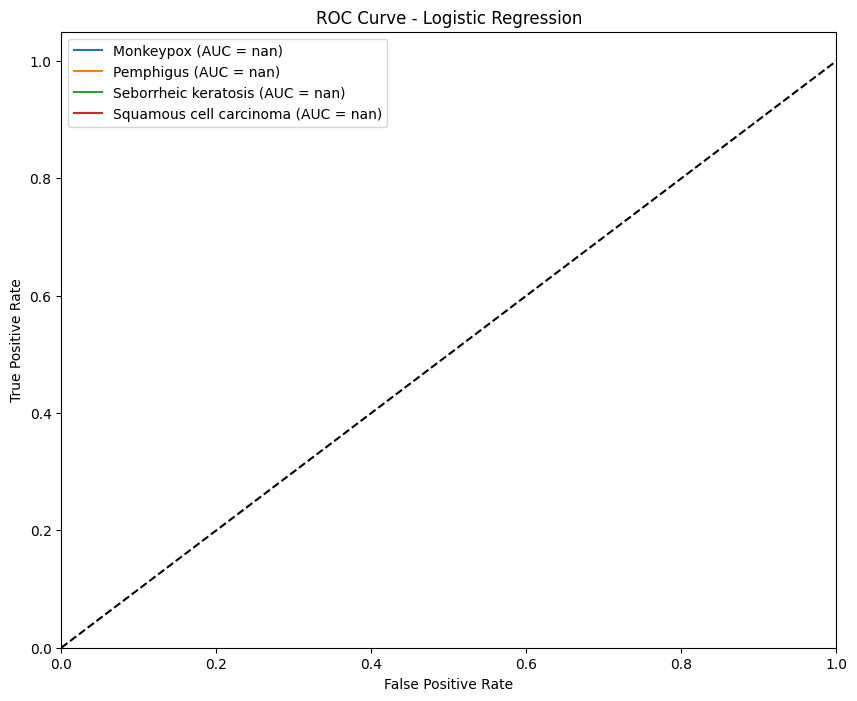

In [4]:
def train_logistic_regression(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Logistic Regression model
    """
    print("Training Logistic Regression...")
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Logistic Regression")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Logistic Regression")
    
    return model, accuracy



# Logistic Regression
lr_model, lr_accuracy = train_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)




# Logistic Regression Inference 

# SVM

Training Support Vector Machine...

Support Vector Machine Results:
Accuracy: 0.7625
Precision: 0.7637
Recall: 0.7625
F1-Score: 0.7570

Support Vector Machine Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.82      0.70      0.76        20
              Pemphigus       0.86      0.95      0.90        20
   Seborrheic keratosis       0.69      0.55      0.61        20
Squamous cell carcinoma       0.68      0.85      0.76        20

               accuracy                           0.76        80
              macro avg       0.76      0.76      0.76        80
           weighted avg       0.76      0.76      0.76        80



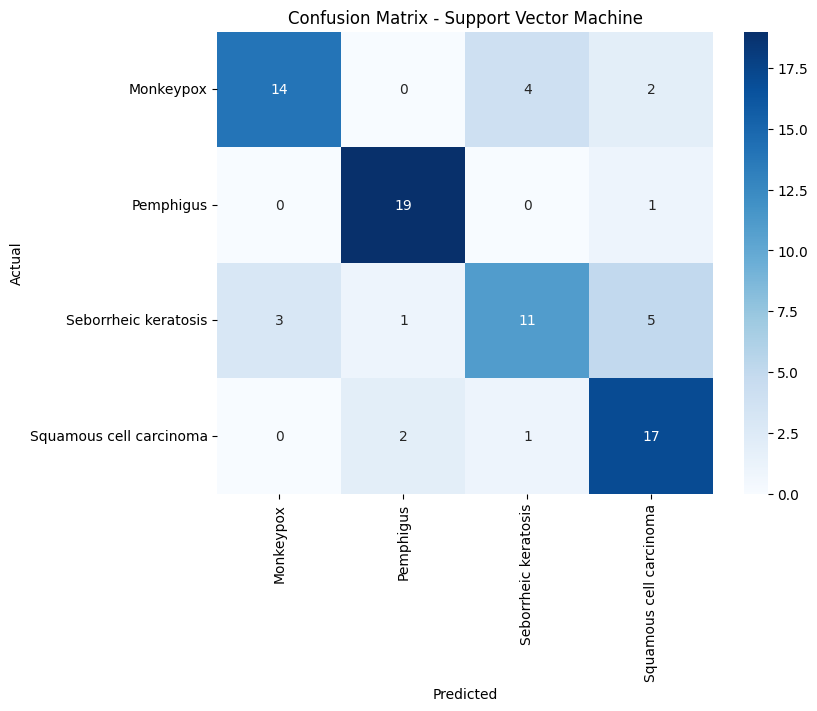

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


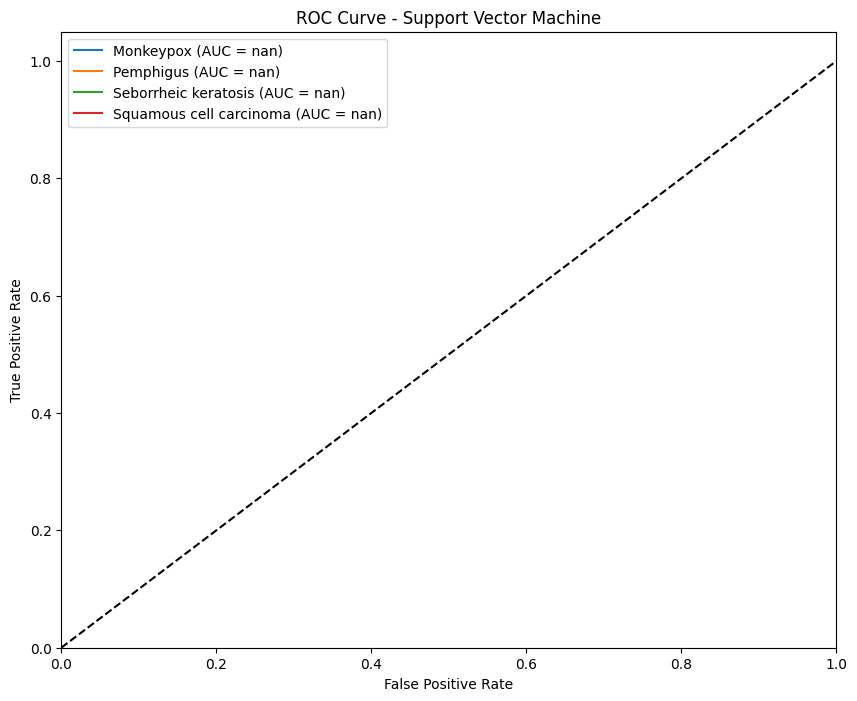

In [5]:
def train_svm(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Support Vector Machine model
    """
    print("Training Support Vector Machine...")
    
    model = SVC(kernel='rbf', probability=True, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Support Vector Machine")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Support Vector Machine")
    
    return model, accuracy


# Support Vector Machine
svm_model, svm_accuracy = train_svm(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)



# Decision tree 

Training Decision Tree...

Decision Tree Results:
Accuracy: 0.4750
Precision: 0.4891
Recall: 0.4750
F1-Score: 0.4703

Decision Tree Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.54      0.70      0.61        20
              Pemphigus       0.54      0.35      0.42        20
   Seborrheic keratosis       0.53      0.40      0.46        20
Squamous cell carcinoma       0.35      0.45      0.39        20

               accuracy                           0.48        80
              macro avg       0.49      0.47      0.47        80
           weighted avg       0.49      0.47      0.47        80



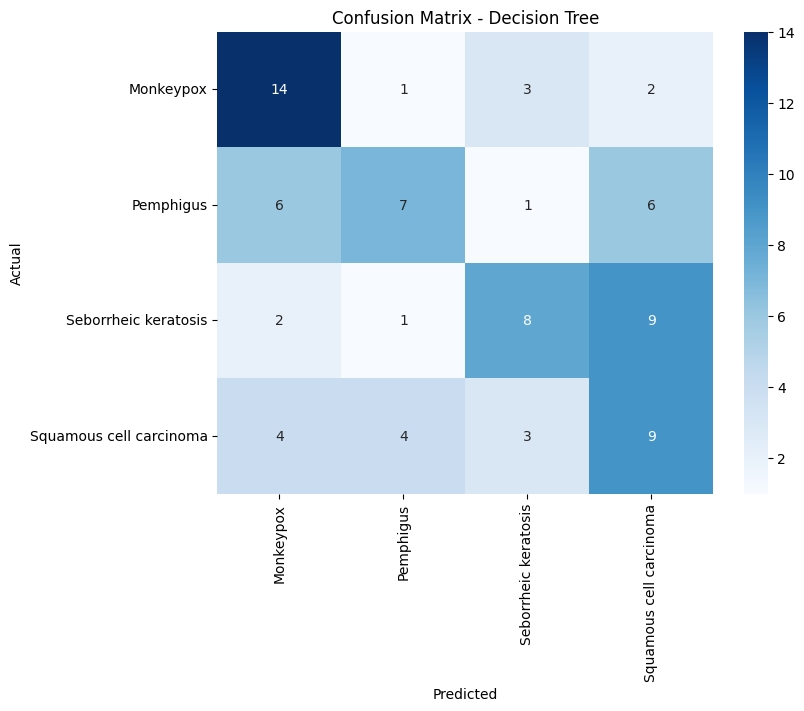

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


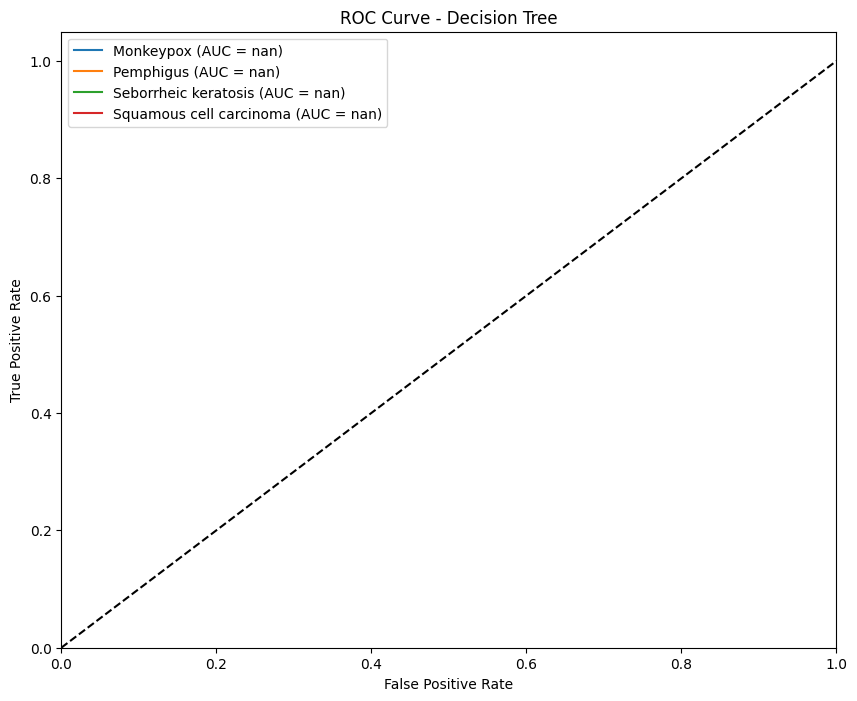

In [6]:
def train_decision_tree(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Decision Tree model
    """
    print("Training Decision Tree...")
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Decision Tree")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Decision Tree")
    
    return model, accuracy


# Decision Tree
dt_model, dt_accuracy = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)



# RF

Training Random Forest...

Random Forest Results:
Accuracy: 0.7250
Precision: 0.7551
Recall: 0.7250
F1-Score: 0.7301

Random Forest Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.87      0.65      0.74        20
              Pemphigus       0.88      0.75      0.81        20
   Seborrheic keratosis       0.70      0.70      0.70        20
Squamous cell carcinoma       0.57      0.80      0.67        20

               accuracy                           0.73        80
              macro avg       0.76      0.72      0.73        80
           weighted avg       0.76      0.72      0.73        80



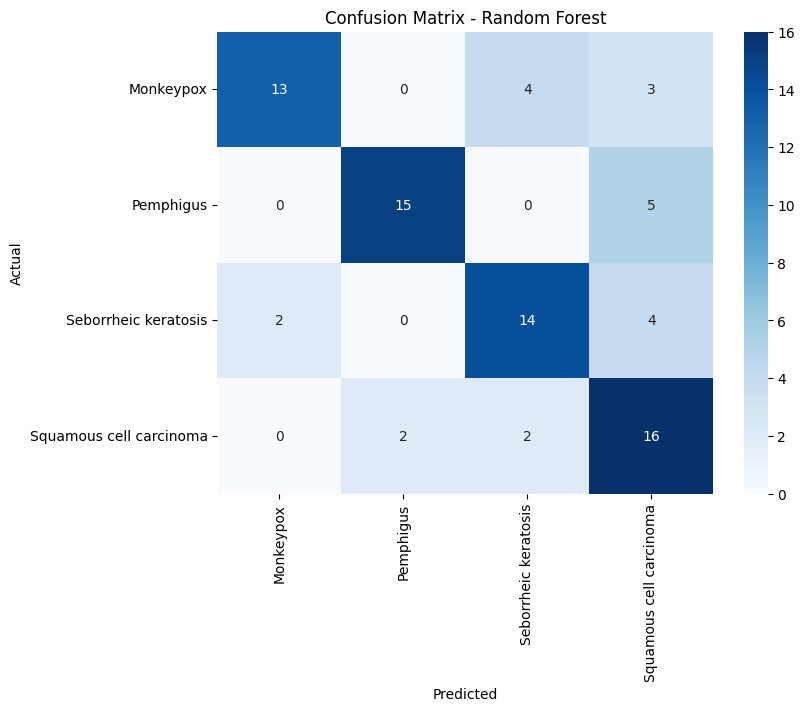

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


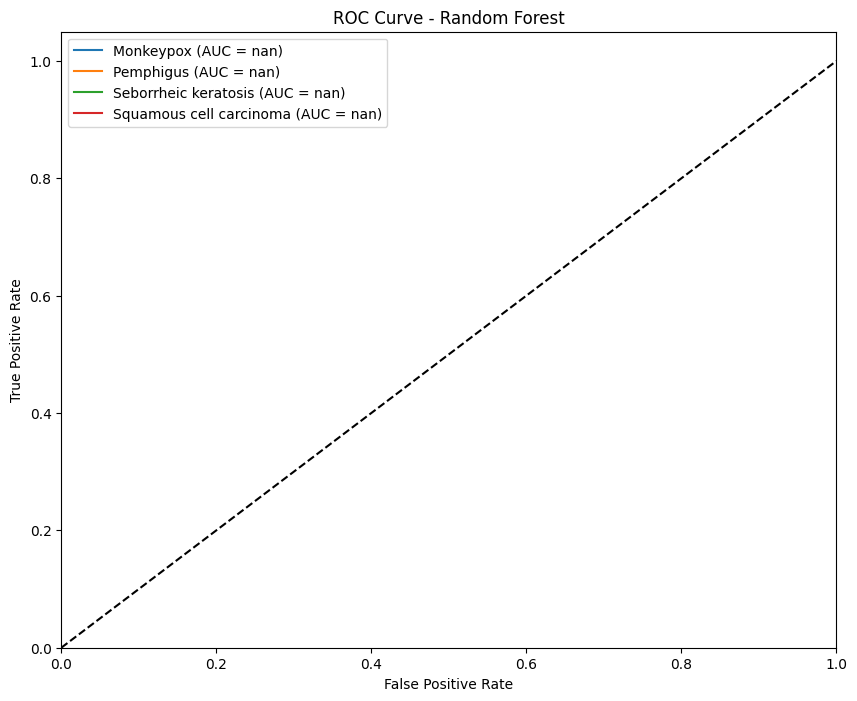

In [7]:
def train_random_forest(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Random Forest model
    """
    print("Training Random Forest...")
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Random Forest")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Random Forest")
    
    return model, accuracy




# Random Forest
rf_model, rf_accuracy = train_random_forest(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    

# CNN

Creating data generators...
Found 1536 images belonging to 4 classes.
Found 384 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Training samples: 1536
Validation samples: 384
Test samples: 80
Classes: ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']

Creating CNN model...
Model created with 1,440,036 parameters

Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4095 - loss: 2.0412
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_medical_cnn.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.4106 - loss: 2.0385 - val_accuracy: 0.2500 - val_loss: 2.6706 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5105 - loss: 1.7401
Epoch 2: val_accuracy improved from 0.25000 to 0.26562, saving model to best_medical_cnn.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.5106 - loss: 1.7404 - val_accuracy: 0.2656 - val_loss: 2.8846 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5983 - loss: 1.6196
Epoch 3: val_accuracy did not improve from 0.26562
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - accuracy: 0.5979 - loss: 1.6199 - val_accuracy: 0.2500 - val_loss: 2.5915 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5988 - loss: 1.585

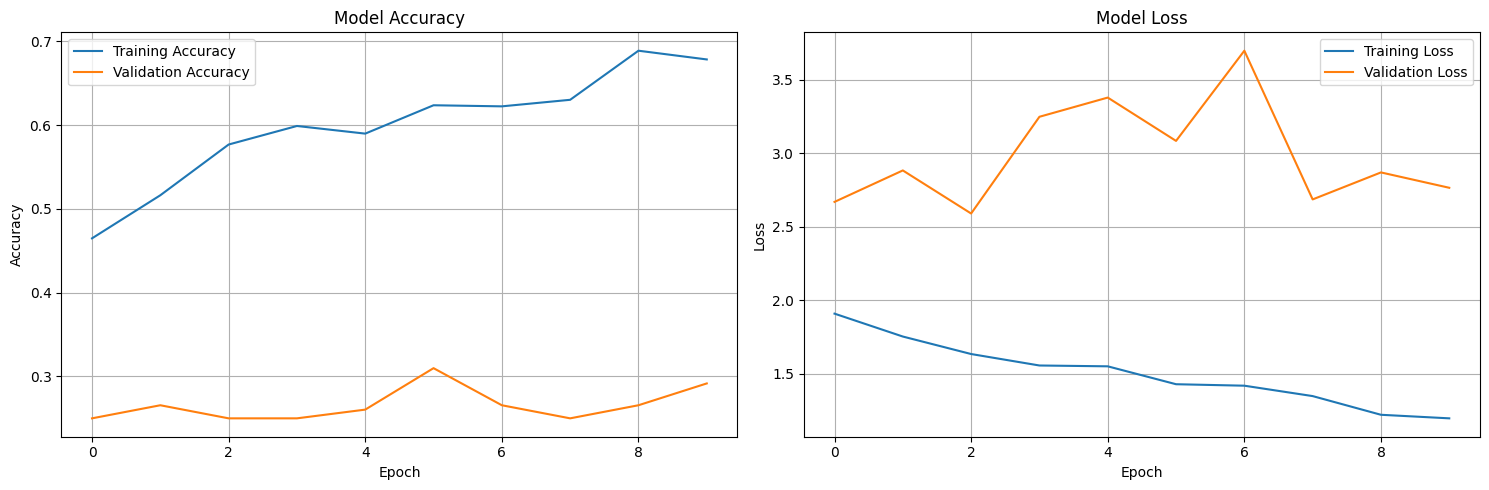


Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step  

Test Accuracy: 0.3500

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
                         precision    recall  f1-score   support

              Monkeypox       0.00      0.00      0.00        20
              Pemphigus       0.00      0.00      0.00        20
   Seborrheic keratosis       0.52      0.60      0.56        20
Squamous cell carcinoma       0.28      0.80      0.42        20

               accuracy                           0.35        80
              macro avg       0.20      0.35      0.24        80
           weighted avg       0.20      0.35      0.24        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


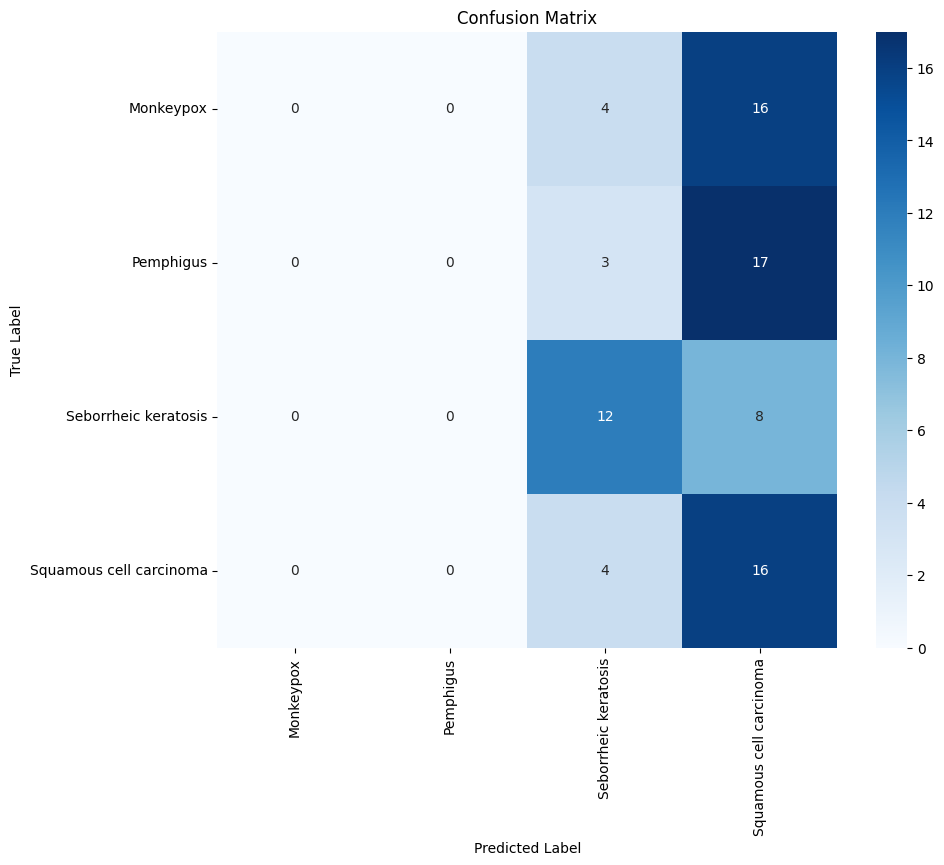


Detailed Results:
Monkeypox: Precision=0.000, Recall=0.000, F1=0.000
Pemphigus: Precision=0.000, Recall=0.000, F1=0.000
Seborrheic keratosis: Precision=0.522, Recall=0.600, F1=0.558
Squamous cell carcinoma: Precision=0.281, Recall=0.800, F1=0.416


In [9]:
# CNN Implementation for Medical Image Classification

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd

# ========================================================================================
# CNN MODEL ARCHITECTURES
# ========================================================================================

class MedicalCNNModels:
    def __init__(self, input_shape=(224, 224, 3), num_classes=4):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def create_simple_cnn(self):
        """
        Simple CNN architecture for medical image classification
        """
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            GlobalAveragePooling2D(),
            Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(self.num_classes, activation='softmax')
        ])
        
        return model
    
    def create_advanced_cnn(self):
        """
        More advanced CNN with residual-like connections
        """
        inputs = Input(shape=self.input_shape)
        
        # First block
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Second block
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Third block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Fourth block
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Global pooling and dense layers
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        model = Model(inputs, outputs)
        return model

# ========================================================================================
# DATA GENERATORS
# ========================================================================================

class DataGenerators:
    def __init__(self, train_dir, test_dir, img_size=(224, 224), batch_size=32):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.img_size = img_size
        self.batch_size = batch_size
        
    def create_generators(self):
        """
        Create data generators for training and testing
        """
        # Training data generator with augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2  # 20% for validation
        )
        
        # Test data generator (only rescaling)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # Training generator
        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        # Validation generator
        validation_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )
        
        # Test generator
        test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        return train_generator, validation_generator, test_generator

# ========================================================================================
# TRAINING AND EVALUATION
# ========================================================================================

class CNNTrainer:
    def __init__(self, model, train_generator, validation_generator, test_generator):
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator
        
    def compile_model(self, learning_rate=0.001):
        """
        Compile the model with optimizer and loss function
        """
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def train_model(self, epochs=50, save_path='best_model.h5'):
        """
        Train the CNN model with callbacks
        """
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001
        )
        
        model_checkpoint = ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
        
        # Train the model
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=len(self.train_generator),
            epochs=epochs,
            validation_data=self.validation_generator,
            validation_steps=len(self.validation_generator),
            callbacks=[early_stopping, reduce_lr, model_checkpoint],
            verbose=1
        )
        
        return history
    
    def evaluate_model(self):
        """
        Evaluate the model on test data
        """
        # Predictions
        predictions = self.model.predict(self.test_generator, verbose=1)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # True labels
        true_classes = self.test_generator.classes
        class_labels = list(self.test_generator.class_indices.keys())
        
        # Calculate metrics
        accuracy = accuracy_score(true_classes, predicted_classes)
        
        # Classification report
        report = classification_report(
            true_classes, predicted_classes,
            target_names=class_labels,
            output_dict=True
        )
        
        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        return accuracy, report, cm, class_labels
    
    def plot_training_history(self, history):
        """
        Plot training history
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        axes[0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0].set_title('Model Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True)
        
        # Loss plot
        axes[1].plot(history.history['loss'], label='Training Loss')
        axes[1].plot(history.history['val_loss'], label='Validation Loss')
        axes[1].set_title('Model Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, cm, class_labels):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# ========================================================================================
# MAIN EXECUTION
# ========================================================================================

def main():
    # Define paths (use the same paths from your existing code)
    augmented_train_path = "/kaggle/working/augmented_train_dataset"
    test_path = "/kaggle/working/test_dataset"
    
    # Create data generators
    print("Creating data generators...")
    data_gen = DataGenerators(augmented_train_path, test_path)
    train_gen, val_gen, test_gen = data_gen.create_generators()
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Test samples: {test_gen.samples}")
    print(f"Classes: {list(train_gen.class_indices.keys())}")
    
    # Create and compile model
    print("\nCreating CNN model...")
    model_builder = MedicalCNNModels(num_classes=4)
    
    # Choose between simple or advanced CNN
    model = model_builder.create_advanced_cnn()  # or create_simple_cnn()
    
    print(f"Model created with {model.count_params():,} parameters")
    
    # Create trainer
    trainer = CNNTrainer(model, train_gen, val_gen, test_gen)
    trainer.compile_model(learning_rate=0.001)
    
    # Train model
    print("\nTraining model...")
    history = trainer.train_model(epochs=10, save_path='best_medical_cnn.h5')
    
    # Plot training history
    trainer.plot_training_history(history)
    
    # Load best model and evaluate
    print("\nEvaluating model...")
    model.load_weights('best_medical_cnn.h5')
    
    accuracy, report, cm, class_labels = trainer.evaluate_model()
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_gen.classes, 
                              np.argmax(model.predict(test_gen), axis=1),
                              target_names=class_labels))
    
    # Plot confusion matrix
    trainer.plot_confusion_matrix(cm, class_labels)
    
    # Print detailed results
    print("\nDetailed Results:")
    for class_name in class_labels:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

if __name__ == "__main__":
    main()

# Main function 

In [ ]:
# ========================================================================================
# MAIN EXECUTION FUNCTION
# ========================================================================================

def main():
    """
    Main function to run the complete pipeline
    """
    # Define paths
    original_path = "/kaggle/input/four-diseases-dataset/Dataset"
    train_path = "/kaggle/working/train_dataset"
    test_path = "/kaggle/working/test_dataset"
    augmented_train_path = "/kaggle/working/augmented_train_dataset"
    
    # Step 1: Split original dataset
    print("Step 1: Splitting original dataset...")
    split_original_dataset(original_path, train_path, test_path)
    
    # Step 2: Augment training data
    print("\nStep 2: Augmenting training data...")
    augment_training_data(train_path, augmented_train_path)
    
    # Step 3: Extract features
    print("\nStep 3: Extracting features...")
    feature_extractor = FeatureExtractor()
    
    # Extract training features
    X_train, y_train = feature_extractor.extract_features_batch(augmented_train_path)
    
    # Extract test features
    X_test, y_test = feature_extractor.extract_features_batch(test_path)
    
    # Step 4: Encode labels
    print("\nStep 4: Encoding labels...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Step 5: Train all models
    print("\nStep 5: Training all models...")
    
    models = {}
    accuracies = {}
    
    # K-Nearest Neighbors
    knn_model, knn_accuracy = train_knn(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['K-Nearest Neighbors'] = knn_model
    accuracies['K-Nearest Neighbors'] = knn_accuracy
    
    # Logistic Regression
    lr_model, lr_accuracy = train_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Logistic Regression'] = lr_model
    accuracies['Logistic Regression'] = lr_accuracy
    
    # Support Vector Machine
    svm_model, svm_accuracy = train_svm(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Support Vector Machine'] = svm_model
    accuracies['Support Vector Machine'] = svm_accuracy
    
    # Decision Tree
    dt_model, dt_accuracy = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Decision Tree'] = dt_model
    accuracies['Decision Tree'] = dt_accuracy
    
    # Random Forest
    rf_model, rf_accuracy = train_random_forest(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Random Forest'] = rf_model
    accuracies['Random Forest'] = rf_accuracy
    
    # Step 6: Compare all models
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
    accuracy_df = accuracy_df.sort_values('Accuracy', ascending=False)
    
    print(accuracy_df.to_string(index=False))
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save best model
    best_model_name = accuracy_df.iloc[0]['Model']
    best_model = models[best_model_name]
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best accuracy: {accuracy_df.iloc[0]['Accuracy']:.4f}")
    
    # Save the best model
    with open('/kaggle/working/best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    
    with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print("\nModels saved successfully!")

# ========================================================================================
# RUN THE PROGRAM
# ========================================================================================

if __name__ == "__main__":
    main()